In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df=pd.read_excel("/content/Online Retail.xlsx")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.shape

(541909, 8)

In [ ]:
df = df.dropna(subset=["CustomerID"])  #Remove missing CustomerID
df = df[df["UnitPrice"] > 0]           #Remove invalid prices
df = df[df["Quantity"] > 0]            #Remove returns

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
#Feature Engineering: RFM Analysis
reference_date = df["InvoiceDate"].max()
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (reference_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("UnitPrice", lambda x: (x * df.loc[x.index, "Quantity"]).sum()),
).reset_index()

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

In [ ]:
#Determine optimal number of clusters
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


##Recency(R): How recently a customer has made a purchase.
##Frequency(F): How often a customer makes purchases.
##Monetary(M): How much money a customer spends.


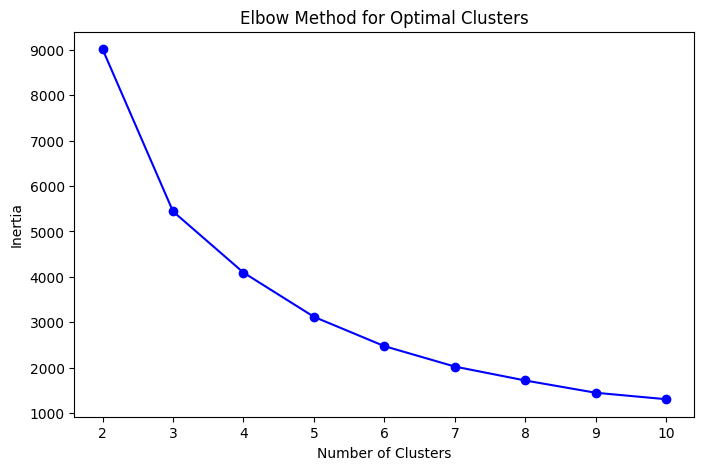

In [ ]:
#Elbow Method helps to find out the best possible clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

In [ ]:
silhouette = silhouette_score(rfm_scaled, rfm["Cluster"])

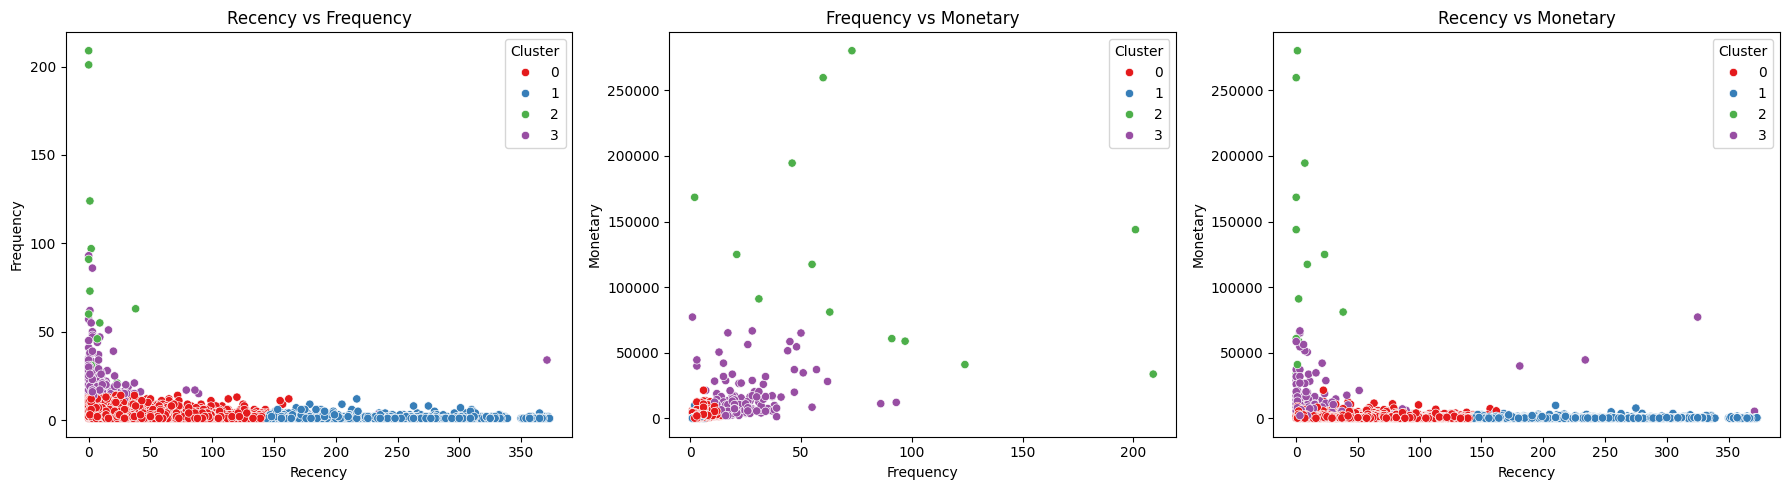

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="Cluster", palette="Set1", ax=axes[0])
axes[0].set_title("Recency vs Frequency")
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="Set1", ax=axes[1])
axes[1].set_title("Frequency vs Monetary")
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="Set1", ax=axes[2])
axes[2].set_title("Recency vs Monetary")
plt.tight_layout()
plt.show()

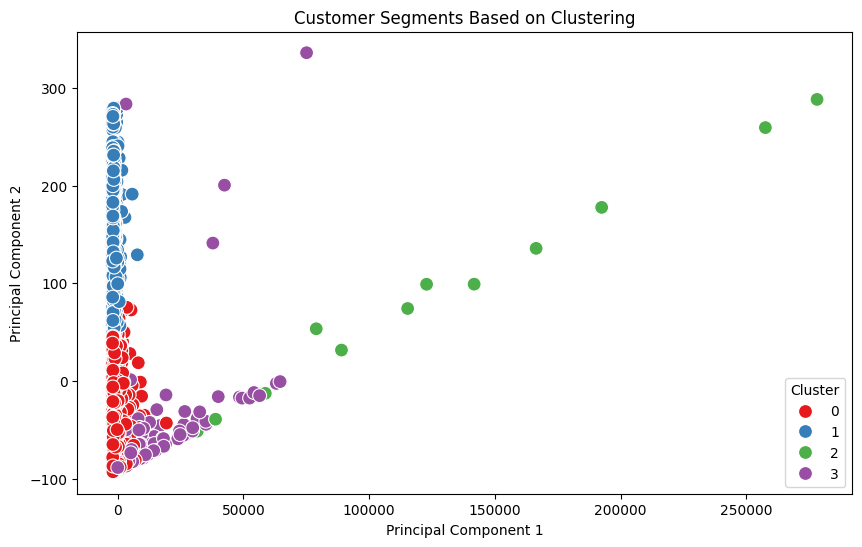

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# Convert to DataFrame
rfm_pca_df = pd.DataFrame(rfm_pca, columns=["PC1", "PC2"])
rfm_pca_df["Cluster"] = rfm["Cluster"]

# Plot clusters in a single scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", s=100)
plt.title("Customer Segments Based on Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


In [ ]:
print("Silhouette Score:", silhouette)
print("Cluster Summary:")
print(rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Count"}))

Silhouette Score: 0.616212846765192
Cluster Summary:
            Recency  Frequency       Monetary  Count
Cluster                                             
0         42.702685   3.682711    1359.049284   3054
1        247.075914   1.552015     480.617480   1067
2          6.384615  82.538462  127338.313846     13
3         14.500000  22.333333   12709.090490    204


In [ ]:
import pickle
with open("kmeans_model.pkl", "wb") as file:
    pickle.dump(kmeans, file)

print("Model saved as kmeans_model.pkl")

Model saved as kmeans_model.pkl


In [ ]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Model saved as scaler.pkl")

Model saved as scaler.pkl
